In [1]:
import os
import sys
sys.path.append('..')  
import random
import pickle

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from scipy.stats import hypergeom

In [4]:
from scregat.data_process import prepare_model_input, sum_counts, plot_edge, ATACGraphDataset
from run_scReGAT import *

/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [5]:
# load graph
with open('../data/dataset_atac_core_MFG.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [6]:
adata_edge = sc.read_h5ad("../data/scRP_MFG.h5ad")
adata_edge

AnnData object with n_obs × n_vars = 1065 × 69180
    obs: 'celltype', 'celltype_rna', 'nb_features'

In [7]:
edge_info = get_edge_info(dataset_atac)

In [8]:
# Differential expression analysis for each cell type using Wilcoxon test

# Get all unique cell types from the AnnData object
cell_types = adata_edge.obs['celltype'].unique()

# Initialize dictionary to store differential expression results
diff_results = {}

for cell_type in cell_types:
    # Perform Wilcoxon rank-sum test for the current cell type
    sc.tl.rank_genes_groups(
        adata_edge, 
        groupby='celltype',
        method='wilcoxon', 
        groups=[cell_type]
    )
    
    # Extract and process results
    df = sc.get.rank_genes_groups_df(adata_edge, group=cell_type)
    df = df.sort_values('logfoldchanges', ascending=False)
    
    # Store results
    diff_results[cell_type] = df.reset_index(drop=True)

### GWAS SNP - cRE (cis-Regulatory Element) Overlap Analysis

In [9]:
snp = pd.read_csv("../data/GWAS/SCZ_GWAS.tsv",sep='\t')

In [10]:
snp = snp.dropna(subset=['CHR_POS'])
snp.shape

(1113, 38)

In [11]:
# ================================================
# Purpose: Identify overlap between GWAS SNPs and candidate regulatory elements (cREs)
# Inputs: 
#   - GWAS SNP data (with chromosome, position, and SNP ID)
#   - ATAC-seq peaks (candidate regulatory elements)
# Output: Overlapping regions between SNPs and cREs
# ================================================

# Prepare SNP data by standardizing chromosome format and positions
# Convert chromosome IDs to 'chrX' format (e.g., '1' -> 'chr1')
snp['chromosome'] = 'chr' + snp['CHR_ID'].astype('str')  # Using string conversion for safety
# Alternative (if CHR_ID contains integers):
# snp['chromosome'] = 'chr' + snp['CHR_ID'].astype('int').astype('str')

# Ensure positions are integers and create SNP ID column
snp['position'] = snp['CHR_POS'].astype('int')  # Convert positions to integers
snp['snpId'] = snp['SNPS']  # Store SNP identifiers

# Keep only essential columns and remove duplicates
snp = snp[['chromosome','position','snpId']]
snp = snp.drop_duplicates()  # Remove any duplicate SNP entries

# Process ATAC-seq peaks (candidate regulatory elements)
# Split peak coordinates (format: 'chr1-1000-2000') into components
peaks_all_df = pd.DataFrame([t.split('-') for t in dataset_atac.array_peak if t.startswith('chr')])

# Reconstruct peak identifier in standard format
peaks_all_df['peak'] = peaks_all_df[0] + "-" + peaks_all_df[1] + "-" + peaks_all_df[2]

# Create reference SNP regions (1bp window around each SNP)
# Bed format uses 0-based start, 1-based end coordinates
ref_se_peak = pd.DataFrame({
    "chr": snp.chromosome.values,
    "start": snp.position.astype('int')-1,  # Convert to 0-based
    "end": snp.position.astype('int')+1,    # 1bp window (position ±1)
    "snp": snp.snpId.values
})

print(f"Shape of SNP reference regions: {ref_se_peak.shape}")

# ================================================
# Find Overlaps Between SNPs and Regulatory Elements
# ================================================
import pybedtools

# Convert DataFrames to BedTool objects for interval operations
se_bed = pybedtools.BedTool.from_dataframe(ref_se_peak)  # SNP regions
all_bed = pybedtools.BedTool.from_dataframe(peaks_all_df)  # ATAC-seq peaks

# Perform intersection analysis:
# - wa: Keep original entries from ATAC peaks (all_bed)
# - wb: Also keep overlapping SNP entries (se_bed)
res = all_bed.intersect(se_bed, wa=True, wb=True)

# Convert results back to DataFrame
result_intersect = res.to_dataframe()
print(f"Shape of overlap results: {result_intersect.shape}")

Shape of SNP reference regions: (1113, 4)
Shape of overlap results: (25, 8)


In [12]:
result_intersect['peak'] = result_intersect.name
result_intersect = pd.merge(edge_info.loc[edge_info.peak.isin(result_intersect.name),],result_intersect,on="peak",how='left')

In [13]:
result_intersect['pairs'] = result_intersect['peak'] + '_' + result_intersect['gene']

In [20]:
edge_index = result_intersect['pairs'].values
edge_index

array(['chr2-212537738-212538409_ERBB4',
       'chr20-38723529-38724029_SLC32A1',
       'chr5-127072894-127073665_MEGF10',
       'chr1-182699454-182699954_RGS16', 'chr1-182699454-182699954_RGS8',
       'chr1-182699454-182699954_NPL', 'chr12-6825491-6825991_LPAR5',
       'chr12-6825491-6825991_CD4', 'chr12-109548721-109549221_FAM222A',
       'chr12-120939497-120939997_CABP1', 'chr14-51188113-51189277_TRIM9',
       'chr15-40274484-40275114_PLCB2', 'chr15-77622540-77623360_LINGO1',
       'chr3-181701957-181702457_SOX2', 'chr4-30821283-30822257_PCDH7',
       'chr4-89704360-89705063_SNCA', 'chr7-100627030-100627816_TSC22D4',
       'chr9-37622487-37622987_FRMPD1', 'chr1-36161635-36162135_COL8A2',
       'chr12-57093651-57094151_ZC3H10', 'chr12-74946123-74946623_KCNC2',
       'chr12-108180107-108180607_CMKLR1',
       'chr12-109548721-109549221_ACACB', 'chr15-58749571-58750973_MYO1E',
       'chr16-68380601-68381101_LCAT', 'chr5-139685968-139686468_PSD2',
       'chr6-96015967-9601

In [22]:
from scipy.stats import hypergeom
import numpy as np
import pandas as pd

# Initialize results storage
results = []

# Define parameters
N_range = range(2000, 10001, 500)  # N values from 2000 to 10000, step 500
total_genes = len(adata_edge.var_names)  # Define total_genes before using it

for cell_type in cell_types:
    print(f"Cell type: {cell_type}")
    
    # Get top genes and calculate unique edge_index count
    top_genes = diff_results[cell_type].head(10000)['names'].tolist()
    n_target = len(np.unique(edge_index))
    
    for N in N_range:
        # Calculate overlap
        overlap = len(set(top_genes[:N]) & set(edge_index))
        
        # Hypergeometric test
        pval = hypergeom.sf(
            k=overlap - 1,
            M=total_genes,
            n=n_target,
            N=N
        )
        
        # Store results
        results.append({
            'Cell Type': cell_type,
            'N': N,
            'Overlap': overlap,
            'p-value': pval
        })
        
        print(f"N = {N:5d} | Overlap = {overlap:3d} | p-value = {pval:.6f}")
    
    print()  # Add empty line between cell types

# Convert results to DataFrame
df_results = pd.DataFrame(results)

Cell type: oligodendrocytes
N =  2000 | Overlap =   0 | p-value = 1.000000
N =  2500 | Overlap =   0 | p-value = 1.000000
N =  3000 | Overlap =   0 | p-value = 1.000000
N =  3500 | Overlap =   0 | p-value = 1.000000
N =  4000 | Overlap =   0 | p-value = 1.000000
N =  4500 | Overlap =   0 | p-value = 1.000000
N =  5000 | Overlap =   0 | p-value = 1.000000
N =  5500 | Overlap =   1 | p-value = 0.909545
N =  6000 | Overlap =   1 | p-value = 0.928033
N =  6500 | Overlap =   1 | p-value = 0.942847
N =  7000 | Overlap =   2 | p-value = 0.806720
N =  7500 | Overlap =   2 | p-value = 0.837694
N =  8000 | Overlap =   2 | p-value = 0.864298
N =  8500 | Overlap =   2 | p-value = 0.887011
N =  9000 | Overlap =   2 | p-value = 0.906296
N =  9500 | Overlap =   2 | p-value = 0.922588
N = 10000 | Overlap =   2 | p-value = 0.936283

Cell type: excitatory_neuron
N =  2000 | Overlap =   1 | p-value = 0.572980
N =  2500 | Overlap =   1 | p-value = 0.656173
N =  3000 | Overlap =   1 | p-value = 0.723609
N 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Nature style settings
def set_nature_style():
    plt.style.use('default')
    sns.set_style("white")
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 7,
        'axes.linewidth': 0.5,
        'lines.linewidth': 1,
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'figure.dpi': 600,
        'legend.frameon': False,
        'legend.fontsize': 7
    })

def plot_enrichment(df_results, disease, width=12, height=8):
    """Plot SNP regulation enrichment (Nature style)"""
    set_nature_style()
    
    # Define cell type order and colors
    cell_order = ['microglia', 'inhibitory_neuron', 'excitatory_neuron',
                 'astrocyte', 'oligodendrocytes', 'polydendrocytes']
    palette = sns.color_palette("tab10", n_colors=len(cell_order))
    
    # Sort data
    df_results['Cell Type'] = pd.Categorical(df_results['Cell Type'], 
                                           categories=cell_order, 
                                           ordered=True)
    df_results = df_results.sort_values('Cell Type')

    # Create figure
    fig, ax = plt.subplots(figsize=(width/2.54, height/2.54))
    
    # Plot -log10(p-values)
    sns.lineplot(
        data=df_results,
        x='N',
        y=-np.log10(df_results['p-value']),
        hue='Cell Type',
        style='Cell Type',
        markers=True,
        dashes=False,
        linewidth=0.8,
        markersize=5,
        palette=palette,
        ax=ax
    )

    # Add significance threshold
    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=0.8)

    # Format plot
    ax.set_title(f"Enrichment of SNP-associated Regulation in {disease}", fontsize=10)
    ax.set_xlabel('Top N Regulation (2000 to 10000)', fontsize=9)
    ax.set_ylabel('-log$\mathregular{_{10}}$(P value)', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    ax.legend(
        title='Cell Type',
        frameon=False,
        fontsize=7,
        title_fontsize=7,
        bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()
    return df_results

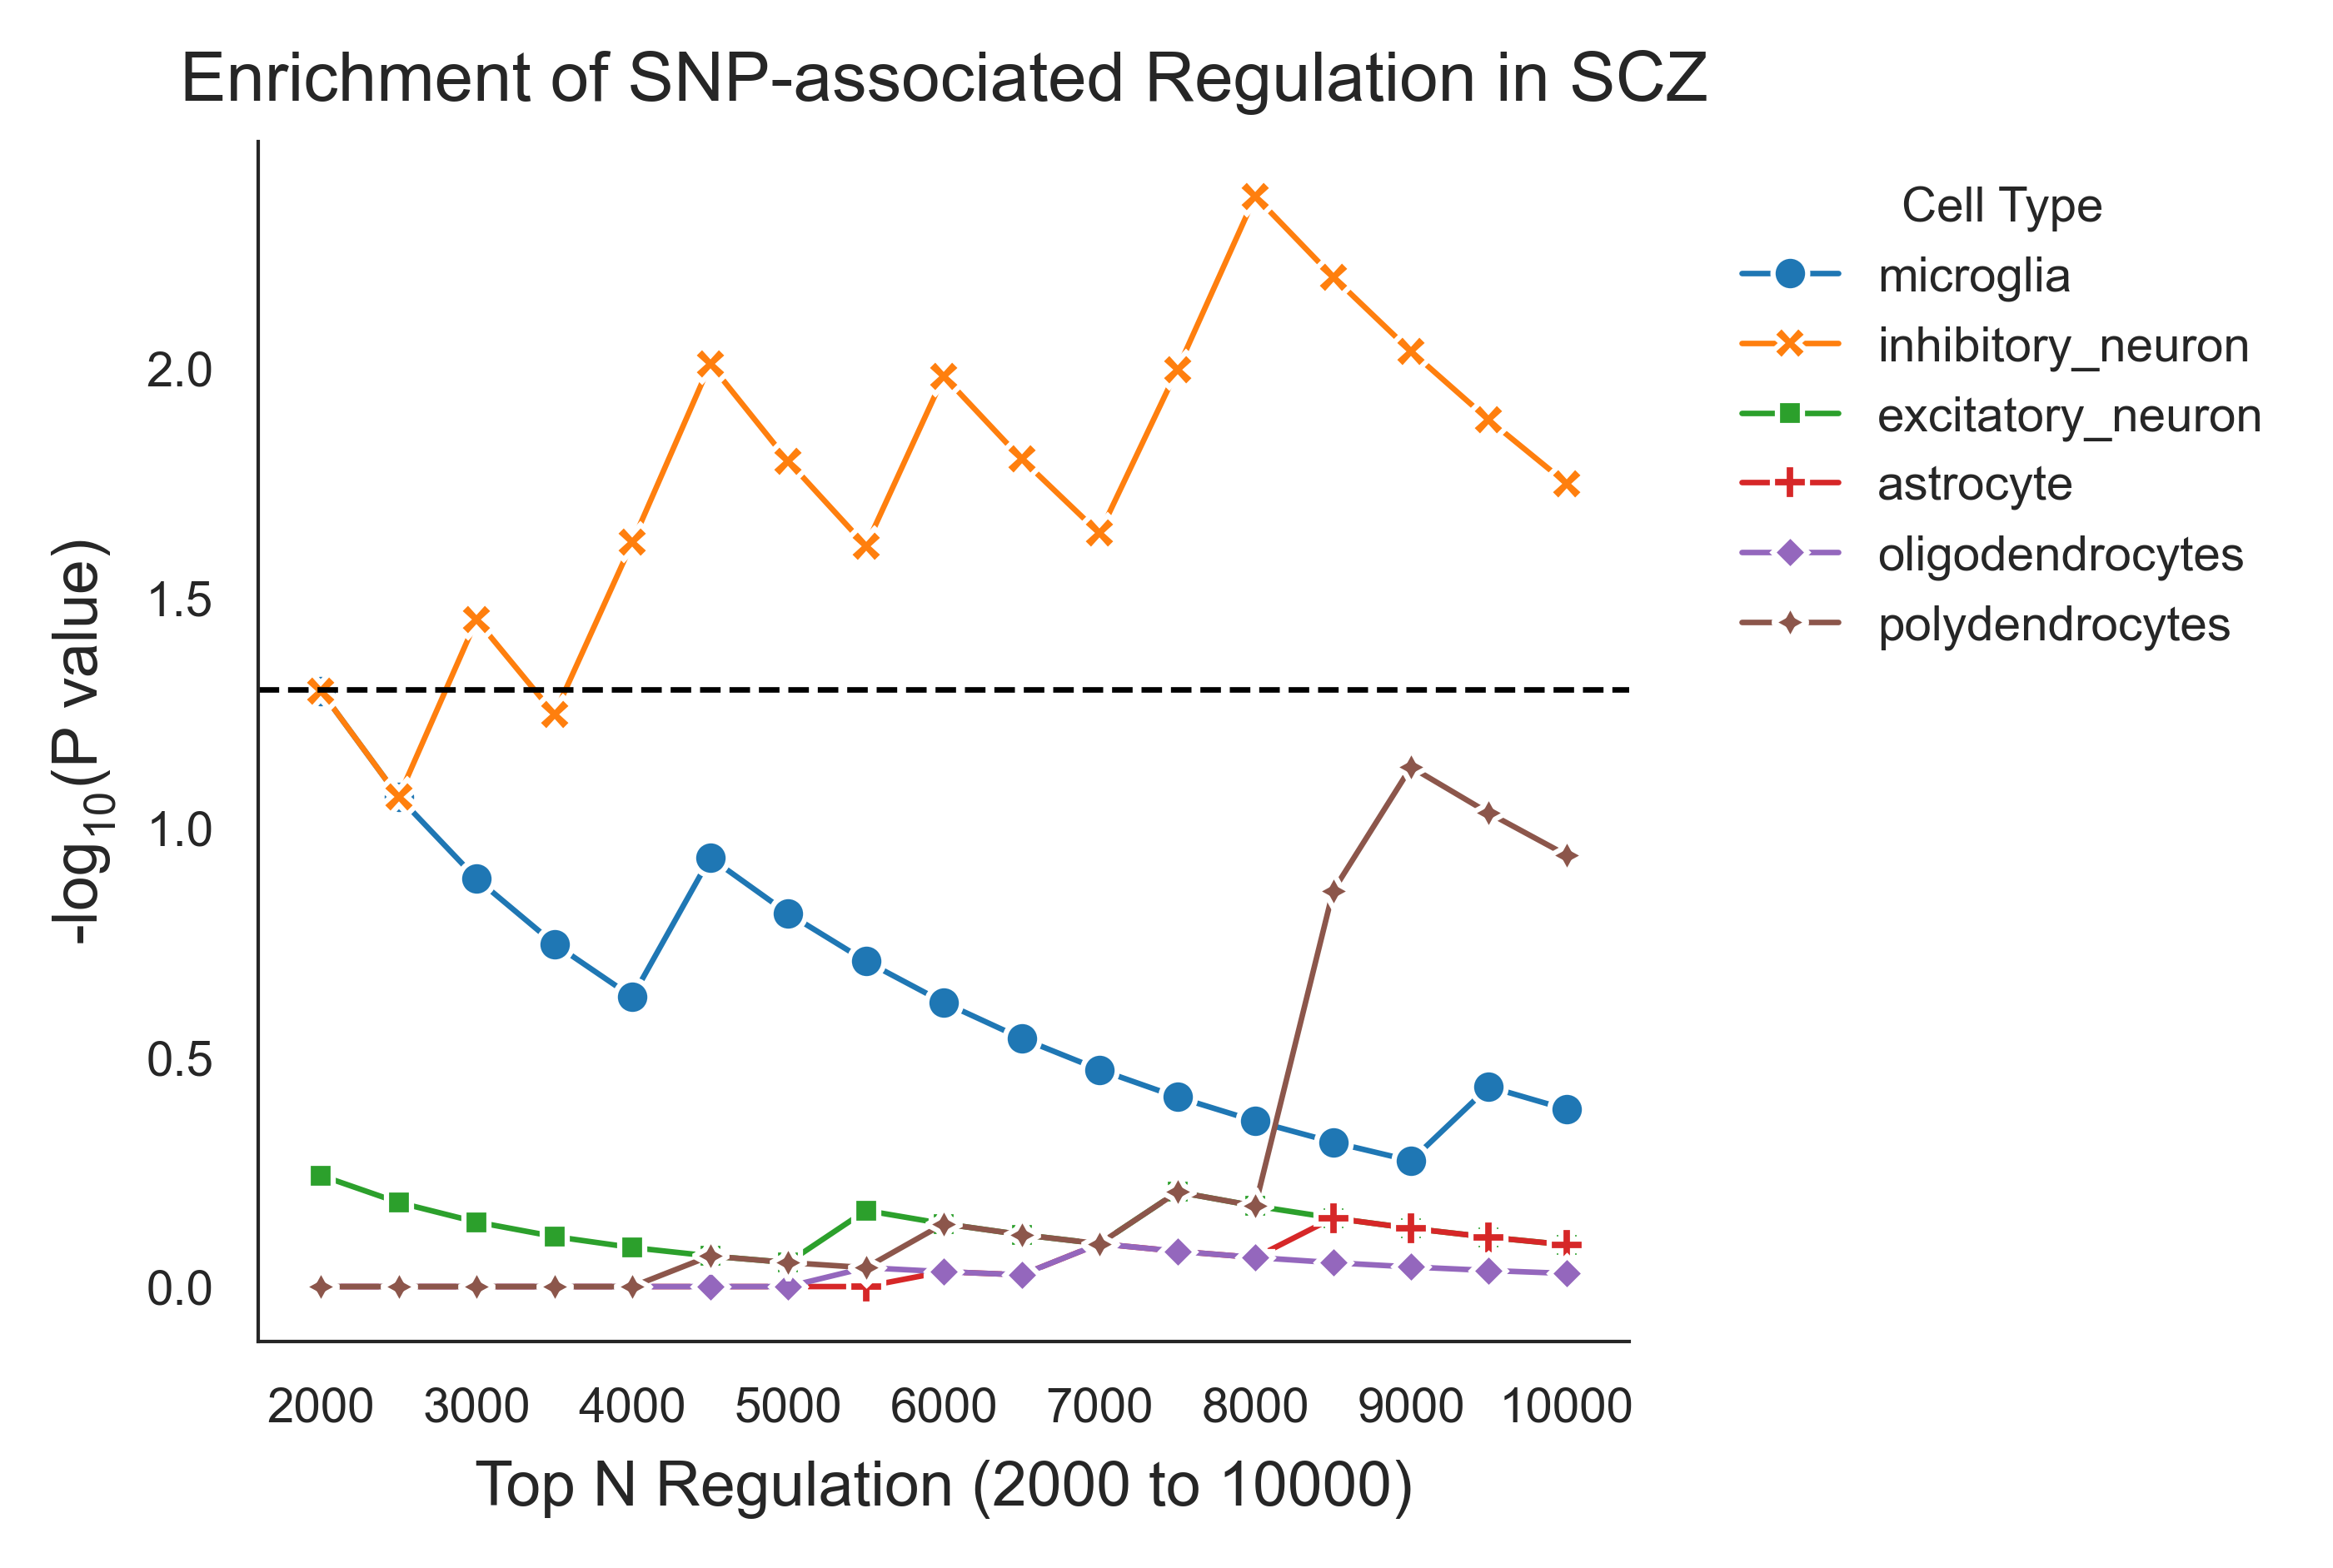

In [34]:
df = plot_enrichment(df_results,disease="SCZ")